# Stochastic Simulation of Trait-Dependent Network Formation

This notebook simulates a stochastic **network formation process** using the Gillespie algorithm.
Each node is assigned a **trait value** \( y_i \in [0,1] \), and links between nodes form with rates:

$$
C(y_i, y_j) = (1 - |y_i - y_j|)^s
$$

Where:
- \( s \) is the **selectivity parameter** (higher → more homophily)
- The more similar two nodes are, the more likely they are to connect

---

## 🔧 Core Gillespie Simulation Code (DO NOT EDIT BELOW)


In [122]:
import numpy as np


def sample_event_time(propensities, rng=np.random.default_rng()):
    total_rate = sum(propensities)
    if total_rate == 0:
        return np.inf, None
    r1 = rng.uniform()
    tau = (1 / total_rate) * np.log(1 / r1)
    r2 = rng.uniform() * total_rate
    cumulative = 0.0
    for k, a in enumerate(propensities):
        cumulative += a
        if r2 <= cumulative:
            return tau, k
    return tau, len(propensities) - 1


def simulate_dynamic_process(initial_state, get_propensities, update_fn, t_max, rng=np.random.default_rng()):
    t = 0.0
    state = initial_state
    times = [t]
    states = [state]

    while t < t_max:
        rates = get_propensities(state)
        if sum(rates) == 0:
            break
        tau, event_idx = sample_event_time(rates, rng)
        t += tau
        if t > t_max:
            break
        state = update_fn(state, event_idx)
        times.append(t)
        states.append(state)

    return times, states


# Step 1: Define Initial Network State

Each node is assigned a trait \( y_i \in [0,1] \), sampled uniformly.
The state is a dictionary with:
- `traits`: the array of node traits
- `edges`: a set of current edges (unordered pairs)

---


In [123]:
def initialize_network(n_nodes=20, seed=0):
    rng = np.random.default_rng(seed)
    traits = rng.uniform(0, 1, size=n_nodes)
    return {"traits": traits, "edges": set()}



In [124]:
def plot_network(state, title="Network Visualization", node_size=100, edge_width=5):
    import matplotlib.pyplot as plt
    import networkx as nx

    G = nx.Graph()
    G.add_nodes_from(range(len(state["traits"])))
    G.add_edges_from(state["edges"])

    # Try Graphviz layout, fall back to spring layout
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog="neato")
    except (ImportError, FileNotFoundError):
        pos = nx.spring_layout(G, seed=42)

    node_colors = state["traits"]
    cmap = plt.cm.binary  # black and white gradient

    fig, ax = plt.subplots(figsize=(8, 5))

    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=cmap,
        node_size=node_size,        # small nodes
        edgecolors='black',   # add border to help node stand out
        ax=ax
    )
    nx.draw_networkx_edges(
        G, pos,
        edge_color='black',
        width=edge_width,           # <- thicker edges
        ax=ax
    )
    # nx.draw_networkx_labels(G, pos, font_color='white', font_size=5, ax=ax)

    # Colorbar for traits
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Trait", rotation=270, labelpad=10)

    ax.set_title(title, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(True)  # <- keep box outline

    plt.tight_layout()
    plt.show()


In [125]:
def get_cluster_size_distribution(state, N=None):
    """
    Returns a NumPy array `counts` where counts[k] = number of components of size k.
    Optionally pads the array to length N (e.g., total number of nodes).
    """
    import numpy as np
    import networkx as nx
    from collections import Counter

    G = nx.Graph()
    G.add_nodes_from(range(len(state["traits"])))
    G.add_edges_from(state["edges"])

    sizes = [len(c) for c in nx.connected_components(G)]
    counter = Counter(sizes)

    max_size = max(counter) if not N else N
    counts = np.zeros(max_size + 1, dtype=int)

    for size, count in counter.items():
        counts[size] = count

    return counts


# Step 2: Define Propensity and Update Rules Based on Traits

Links form between nodes \( i \) and \( j \) with rate:

$$
C(y_i, y_j) = (1 - |y_i - y_j|)^s
$$

This is the **selectivity kernel**.
We create:
- A `get_propensities(state, t)` function to return current event rates
- An `update_fn(state, event_idx)` to add the selected link

---


In [126]:
def propensity_fn_factory(s):
    def get_propensities(state):
        traits = state["traits"]
        edges = state["edges"]
        n = len(traits)
        propensities = []
        pairs = []

        for i in range(n):
            for j in range(i + 1, n):
                if (i, j) not in edges and (j, i) not in edges:  # ensure undirected
                    diff = abs(traits[i] - traits[j])
                    rate = (1 - diff) ** s
                    propensities.append(rate)
                    pairs.append((i, j))

        # Make a deep copy of the pairs for this step only
        state["event_targets"] = pairs
        return propensities
    return get_propensities


def update_fn(state, event_idx):
    """
    Given state and selected event index, adds the selected link.
    """
    i, j = state["event_targets"][event_idx]
    new_edges = state["edges"].copy()
    new_edges.add((i, j))
    return {
        "traits": state["traits"],
        "edges": new_edges
    }


# ▶️ Step 3.0: Piecing it Together


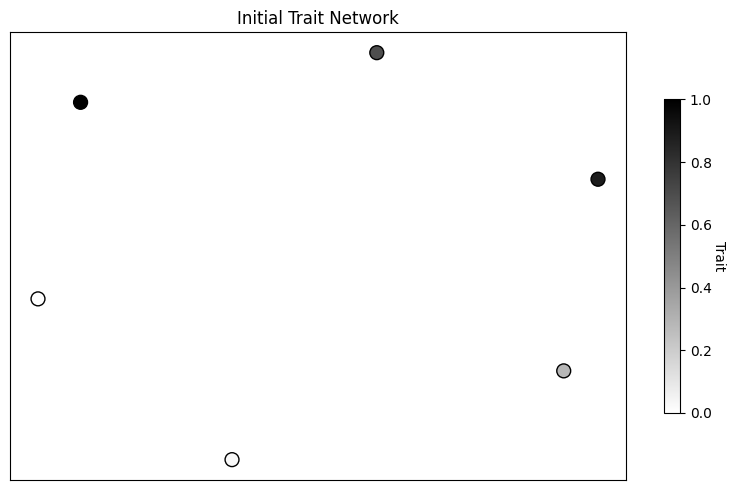

0: (0, 1) → rate = 0.10149
1: (0, 2) → rate = 0.01076
2: (0, 3) → rate = 0.00788
3: (0, 4) → rate = 0.37916
4: (0, 5) → rate = 0.19921
5: (1, 2) → rate = 0.27277
6: (1, 3) → rate = 0.23219
7: (1, 4) → rate = 0.01983
8: (1, 5) → rate = 0.00580
9: (2, 3) → rate = 0.88360
10: (2, 4) → rate = 0.00061
11: (2, 5) → rate = 0.00003
12: (3, 4) → rate = 0.00035
13: (3, 5) → rate = 0.00001
14: (4, 5) → rate = 0.59218


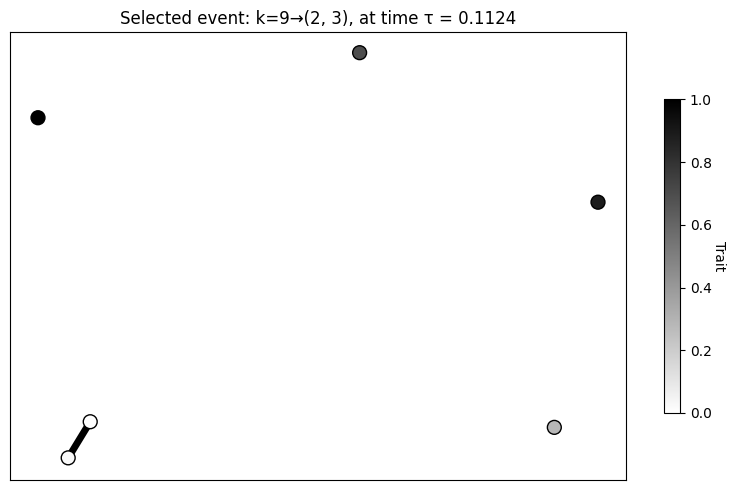

0: (0, 1) → rate = 0.10149
1: (0, 2) → rate = 0.01076
2: (0, 3) → rate = 0.00788
3: (0, 4) → rate = 0.37916
4: (0, 5) → rate = 0.19921
5: (1, 2) → rate = 0.27277
6: (1, 3) → rate = 0.23219
7: (1, 4) → rate = 0.01983
8: (1, 5) → rate = 0.00580
9: (2, 4) → rate = 0.00061
10: (2, 5) → rate = 0.00003
11: (3, 4) → rate = 0.00035
12: (3, 5) → rate = 0.00001
13: (4, 5) → rate = 0.59218


In [127]:
from numpy.random import default_rng
rng=np.random.default_rng()

# Step 1:  Initialize
S = initialize_network(n_nodes=6, seed=0)
get_propensity = propensity_fn_factory(s=5.0)
rates = get_propensity(S)

# Looking at network and rates
plot_network(S, title="Initial Trait Network")
for k, ((i, j), r) in enumerate(zip(S["event_targets"], rates)):
    print(f"{k}: ({i}, {j}) → rate = {r:.5f}")

# Step 2:  Update
tau, idx = sample_event_time(rates, rng)
pair = S['event_targets'][idx]
# print(f"**Selected event**: k={idx}->{S['event_targets'][idx]}, at time τ = {tau:.4f}")
S = update_fn(S, idx)
rates = get_propensity(S)

# Looking at network and rates
plot_network(S, title=f"Selected event: k={idx}→{pair}, at time τ = {tau:.4f}")
for k, ((i, j), r) in enumerate(zip(S["event_targets"], rates)):
    print(f"{k}: ({i}, {j}) → rate = {r:.5f}")



# 🔄 Step 3.1: Simulate Trait-Based Network Formation

Now that we’ve seen how individual events are sampled based on trait similarity, we’ll run a full **trait-dependent network formation simulation** using the Gillespie algorithm.

In this setup:
- Each node has a fixed trait $y_i \in [0,1]$
- Links are stochastically formed between unconnected pairs $(i, j)$ with rate:

$$
C(y_i, y_j) = (1 - |y_i - y_j|)^s
$$

- The parameter $s$ controls **selectivity** or **homophily**:
  - Higher $s$: nodes strongly prefer similar partners
  - Lower $s$: link formation becomes more random
- The process continues until a time limit $t_{\text{max}}$ is reached or no more events are possible

The function below wraps everything together using:
- An initial network with trait values
- The propensity function from Step 2
- The generic Gillespie simulator `simulate_dynamic_process`

It returns:
- A list of event times
- A list of full system states at each event


In [145]:
def run_trait_network_simulation(n_nodes=30, s=5.0, t_max=5.0, seed=0):
    """
    Runs the full trait-based network formation simulation using the Gillespie algorithm.

    Parameters:
    - n_nodes: number of nodes in the network
    - s: selectivity parameter for the propensity function
    - t_max: maximum simulation time
    - seed: random seed for reproducibility

    Returns:
    - times: list of event times
    - states: list of system states (dicts with 'traits' and 'edges') at each event
    """
    rng = np.random.default_rng(seed)
    initial_state = initialize_network(n_nodes=n_nodes, seed=seed)
    get_propensities = propensity_fn_factory(s)
    update = update_fn

    times, states = simulate_dynamic_process(
        initial_state=initial_state,
        get_propensities=get_propensities,
        update_fn=update,
        t_max=t_max,
        rng=rng
    )

    return times, states


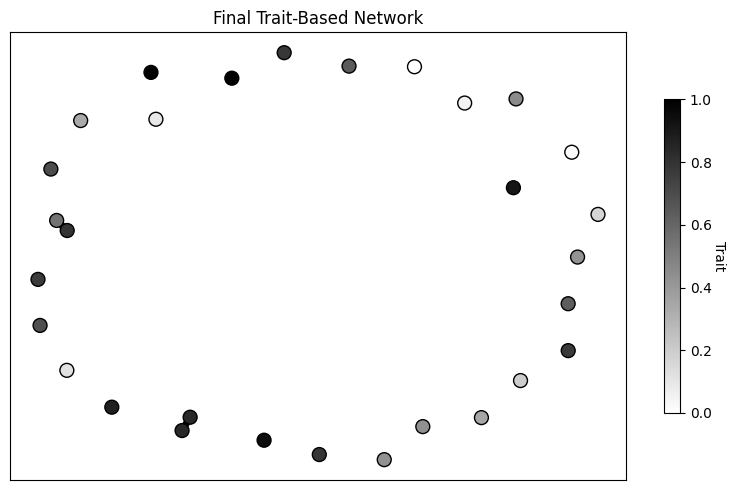

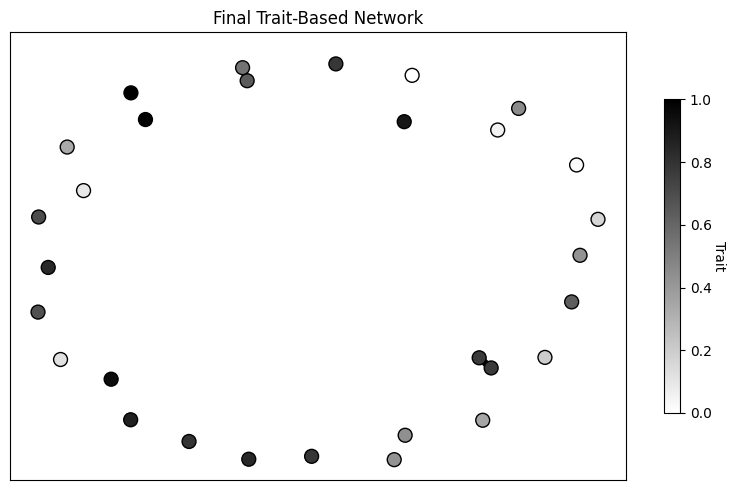

In [146]:
t_c = lambda N,s: (s+2)/(2*N)

seed=42
N=30
alpha = 0.1

# Example simulation run homogenous
s =0
t_max = t_c(N,s)
times, states = run_trait_network_simulation(n_nodes=30, s=s, t_max=alpha*t_max, seed=seed)
plot_network(states[-1], title="Final Trait-Based Network")

# Example simulation run dependence on heterogeniety
s =10
t_max = t_c(N,s)
times, states = run_trait_network_simulation(n_nodes=30, s=s, t_max=alpha*t_max, seed=seed)
plot_network(states[-1], title="Final Trait-Based Network")



# Trajectory of Monomers

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_trait_simulation_trajectories(N=100, s=5.0, n_runs=30, seed=42):
    tc = (s + 2) / (2 * N)
    t_max = 2 * tc

    mono_trajectories = []
    gel_trajectories = []
    cluster_count_trajectories = []

    for i in range(n_runs):
        times, states = run_trait_network_simulation(N, s=s, t_max=t_max, seed=seed+i)

        monomers = []
        gels = []
        num_clusters = []

        for state in states:
            G = nx.Graph()
            G.add_nodes_from(range(N))
            G.add_edges_from(state["edges"])
            sizes = [len(c) for c in nx.connected_components(G)]
            monomers.append(sizes.count(1) / N)
            gels.append(max(sizes) / N)
            num_clusters.append(len(sizes))

        mono_trajectories.append((np.array(times), monomers))
        gel_trajectories.append((np.array(times), gels))
        cluster_count_trajectories.append((np.array(times), num_clusters))

    # --- Plotting ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    for times, yvals in mono_trajectories:
        axs[0].plot(times / tc, yvals, alpha=0.3, color='black')
    axs[0].set_title("Monomer Fraction $n_1(t)/N$")
    axs[0].set_ylabel("Fraction")
    axs[0].axvline(1, color='red', linestyle='--')

    for times, yvals in gel_trajectories:
        axs[1].plot(times / tc, yvals, alpha=0.3, color='black')
    axs[1].set_title("Gel Size $G(t)/N$")
    axs[1].axvline(1, color='red', linestyle='--')

    for times, yvals in cluster_count_trajectories:
        axs[2].plot(times / tc, yvals, alpha=0.3, color='black')
    axs[2].set_title("Number of Clusters")
    axs[2].axvline(1, color='red', linestyle='--')

    for ax in axs:
        ax.set_xlabel(r"Scaled Time $t/t_c$")
        ax.grid(True)

    plt.suptitle(f"Trait-Based Aggregation Dynamics (N={N}, s={s})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


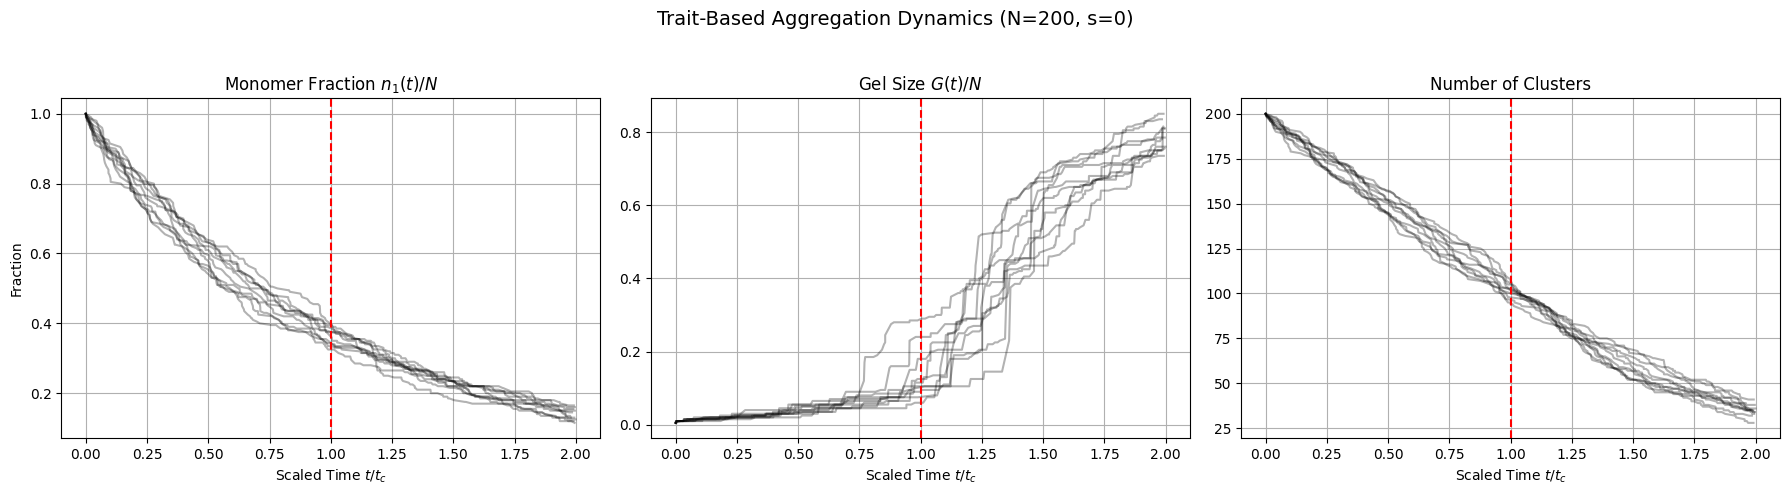

In [153]:
plot_trait_simulation_trajectories(N=200, s=0, n_runs=10, seed=42)


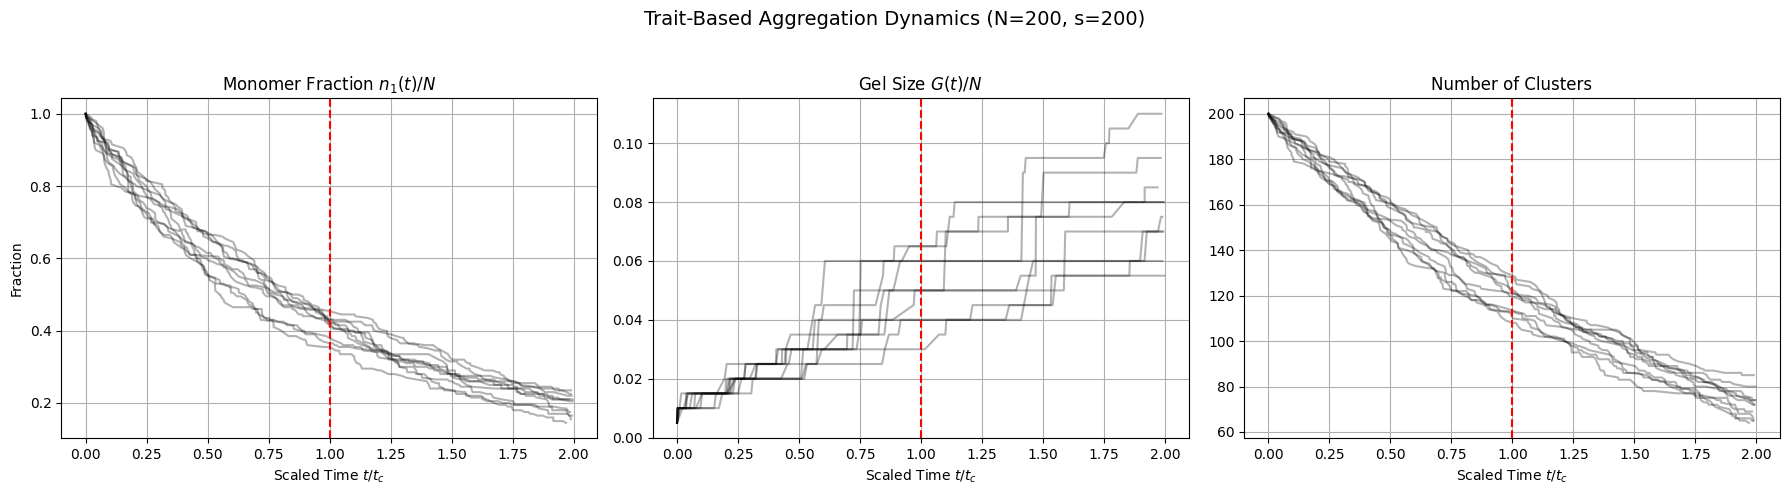

In [155]:
plot_trait_simulation_trajectories(N=200, s=200, n_runs=10, seed=42)